In [1]:
import pandas as pd
import os
import json
import csv
import re, datetime
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date, timedelta

from lifelines import KaplanMeierFitter

from global_functions import *
from rq1_functions import *

In [2]:
FIGS_PATH = 'figs'+os.sep+'RQ0'
if not os.path.exists(FIGS_PATH):
    os.makedirs(FIGS_PATH)

In [3]:
df_full= pd.read_csv('./data/bugs_full.zip',index_col=False,compression='zip',dtype={'release':str,'version':str})
df_full.head()

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,alias,assigned_to,assigned_to_detail.email,assigned_to_detail.id,assigned_to_detail.name,assigned_to_detail.real_name,blocks,cc,cc_detail,classification,...,qa_contact_detail.real_name,resolution,see_also,severity,status,summary,target_milestone,url,version,whiteboard
0,[],Lars.Vogel@vogella.com,Lars.Vogel@vogella.com,31345,Lars.Vogel@vogella.com,Lars Vogel,[],"['Lars.Vogel@vogella.com', 'simon.scholz@vogel...","[{'id': 31345, 'email': 'Lars.Vogel@vogella.co...",Eclipse,...,NaN,FIXED,"['https://git.eclipse.org/r/54078', 'https://g...",normal,RESOLVED,Remove redundant type arguments (1.7 or highte...,4.6 M2,NaN,4.5,NaN
1,[],simon.scholz@vogella.com,simon.scholz@vogella.com,140999,simon.scholz@vogella.com,Simon Scholz,[],['Lars.Vogel@vogella.com'],"[{'name': 'Lars.Vogel@vogella.com', 'real_name...",Eclipse,...,NaN,FIXED,"['https://git.eclipse.org/r/54086', 'https://g...",minor,RESOLVED,[Model Editor] The ModelEditor should use a De...,4.6 M2,NaN,4.6,NaN
2,[],platform-swt-inbox@eclipse.org,platform-swt-inbox@eclipse.org,2206,platform-swt-inbox@eclipse.org,Platform-SWT-Inbox,[],"['daniel_megert@ch.ibm.com', 'ericwill@redhat....","[{'real_name': 'Dani Megert', 'name': 'daniel_...",Eclipse,...,NaN,DUPLICATE,[],minor,CLOSED,Initial scrollbar position incorrect,---,NaN,4.5,NaN
3,[],Platform-UI-Inbox@eclipse.org,Platform-UI-Inbox@eclipse.org,2169,Platform-UI-Inbox@eclipse.org,Platform-UI-Inbox,[],[],[],Eclipse,...,NaN,NaN,[],normal,NEW,Perpective overlay the welcome screen,---,NaN,4.5,NaN
4,[],platform-releng-inbox@eclipse.org,platform-releng-inbox@eclipse.org,2217,platform-releng-inbox@eclipse.org,Platform-Releng-Inbox,[],"['mistria@redhat.com', 'tjwatson@us.ibm.com']","[{'real_name': 'Mickael Istria', 'name': 'mist...",Eclipse,...,NaN,FIXED,[],normal,RESOLVED,rt.equinox.bundles-Gerrit has been running fo...,---,NaN,4.5,NaN


In [4]:
yearly_file = '.'+os.sep+'data'+os.sep+'bugs_info.zip'
df = pd.read_csv(yearly_file,index_col=False,compression='zip',dtype={'release':str,'version':str})
df = df.fillna('')
df['release'] = df.apply(lambda x : str(assign_to_closest_minor(x['version'])), axis=1)
df['release'] = df['release'].astype(str)
df = trans_to_datetime(df,['creation_time','first_assignment_date','last_assignment_date',
                          'first_resolved_date','last_resolved_date',
                           'first_fixed_date','last_fixed_date'])

df = attach_severity_priority_to_dataframe(df)
df.head()

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


,id,release,Product,creation_time,version,resolution,is_assigned,is_resolved,is_fixed,first_assignment_date,...,last_fixed_date,time_assign_diff,time_resolve_diff,time_fix_diff,min_release,max_release,min_release_before_version_field,min_release_after_version_field,severity,priority
0,475361,4.5,Platform,2015-08-19 10:50:25,4.5,FIXED,0,1,1,NaT,...,2015-08-19 11:53:03,,0,0,4.5,4.5,False,False,normal,P3
1,475365,4.6,Platform,2015-08-19 11:34:37,4.6,FIXED,0,1,1,NaT,...,2015-08-26 14:29:30,,0,0,4.6,4.6,False,False,minor,P3
2,475370,4.5,Platform,2015-08-19 12:09:06,4.5,DUPLICATE,0,0,0,NaT,...,NaT,,,,4.5,4.5,False,False,minor,P3
3,475379,4.5,Platform,2015-08-19 13:39:12,4.5,,0,0,0,NaT,...,NaT,,,,4.5,4.5,False,False,normal,P3
4,475407,4.5,Platform,2015-08-19 17:06:10,4.5,FIXED,0,1,1,NaT,...,2015-08-19 17:15:25,,0,0,4.5,4.5,False,False,normal,P3


In [5]:
relase_creation_ts_all = get_release_dates()

In [6]:
yearly_file = '.'+os.sep+'data'+os.sep+'bugs_info.zip'
df = pd.read_csv(yearly_file,index_col=False,compression='zip',dtype={'release':str,'version':str})
df = df.fillna('')
df['release'] = df.apply(lambda x : str(assign_to_closest_minor(x['version'])), axis=1)
df['release'] = df['release'].astype(str)
df = trans_to_datetime(df,['creation_time','first_assignment_date','last_assignment_date',
                          'first_resolved_date','last_resolved_date',
                           'first_fixed_date','last_fixed_date'])

df.head()

,id,release,Product,creation_time,version,resolution,is_assigned,is_resolved,is_fixed,first_assignment_date,...,last_resolved_date,first_fixed_date,last_fixed_date,time_assign_diff,time_resolve_diff,time_fix_diff,min_release,max_release,min_release_before_version_field,min_release_after_version_field
0,475361,4.5,Platform,2015-08-19 10:50:25,4.5,FIXED,0,1,1,NaT,...,2015-08-19 11:53:03,2015-08-19 11:53:03,2015-08-19 11:53:03,,0,0,4.5,4.5,False,False
1,475365,4.6,Platform,2015-08-19 11:34:37,4.6,FIXED,0,1,1,NaT,...,2015-08-26 14:29:30,2015-08-26 14:29:30,2015-08-26 14:29:30,,0,0,4.6,4.6,False,False
2,475370,4.5,Platform,2015-08-19 12:09:06,4.5,DUPLICATE,0,0,0,NaT,...,NaT,NaT,NaT,,,,4.5,4.5,False,False
3,475379,4.5,Platform,2015-08-19 13:39:12,4.5,,0,0,0,NaT,...,NaT,NaT,NaT,,,,4.5,4.5,False,False
4,475407,4.5,Platform,2015-08-19 17:06:10,4.5,FIXED,0,1,1,NaT,...,2015-08-19 17:15:25,2015-08-19 17:15:25,2015-08-19 17:15:25,,0,0,4.5,4.5,False,False


In [7]:
df.release.unique()

array(['4.5', '4.6', '4.4', '3.7', '4.2', '4.3', '3.6', '4.8', '3.1',
       '4.7', '4.10', '3.4', '3.5', '3.3', '3.2', '3.0', '4.9'],
      dtype=object)

In [8]:
target_monthly_file = '.'+os.sep+'data'+os.sep+'RQ1'+os.sep+'year_releases_monthly_stats_first_assign_last_resolve_fix.zip'
if not os.path.exists(target_monthly_file):
    df_y_monthly_first = get_monthly_stats(df,relase_creation_ts_all,assignedFirst=True,resolvedFirst=False,fixedFirst=False)
    df_y_monthly_first.to_csv(target_monthly_file,index=False,compression='zip')
else:
    df_y_monthly_first = pd.read_csv(target_monthly_file,index_col=False,compression='zip',
                                    dtype={'release': str})

df_y_monthly_first['release'] = df_y_monthly_first['release'].astype(str)

df_y_monthly_first.head()

,id,release,Product,type,start_period,end_period,month,period
0,64612,3.0,Platform,reported,2004-05-26,2004-06-25,1,before
1,64613,3.0,Platform,reported,2004-05-26,2004-06-25,1,before
2,64614,3.0,Platform,reported,2004-05-26,2004-06-25,1,before
3,64617,3.0,Platform,reported,2004-05-26,2004-06-25,1,before
4,64621,3.0,Platform,reported,2004-05-26,2004-06-25,1,before


In [9]:
#There is no zero month because it is confusing for the figures to have two zero values. 
#It will be adapted only for presentation purposes in the figures
df_y_monthly = df_y_monthly_first[df_y_monthly_first['month']<=12]
df_y_monthly

,id,release,Product,type,start_period,end_period,month,period
0,64612,3.0,Platform,reported,2004-05-26,2004-06-25,1,before
1,64613,3.0,Platform,reported,2004-05-26,2004-06-25,1,before
2,64614,3.0,Platform,reported,2004-05-26,2004-06-25,1,before
3,64617,3.0,Platform,reported,2004-05-26,2004-06-25,1,before
4,64621,3.0,Platform,reported,2004-05-26,2004-06-25,1,before
5,64624,3.0,Platform,reported,2004-05-26,2004-06-25,1,before
6,64625,3.0,Platform,reported,2004-05-26,2004-06-25,1,before
7,64626,3.0,Platform,reported,2004-05-26,2004-06-25,1,before
8,64627,3.0,Platform,reported,2004-05-26,2004-06-25,1,before
9,64628,3.0,Platform,reported,2004-05-26,2004-06-25,1,before


In [10]:
all_stats = pd.DataFrame()
for period_type in df_y_monthly.period.unique():
    pdf_y_monthly = df_y_monthly[df_y_monthly['period']==period_type]

    res_d = (
        pdf_y_monthly[pdf_y_monthly['type']=='resolved']
        .groupby(by=['release','month'])['id']
        .nunique()
        .reset_index()
        .rename(index=str,columns={'id':'resolved_bugs'})
    )
    ass_d = (
        pdf_y_monthly[pdf_y_monthly['type']=='assigned']
        .groupby(by=['release','month'])['id']
        .nunique()
        .reset_index()
        .rename(index=str,columns={'id':'assigned_bugs'})
    )
    rep_d = (
        pdf_y_monthly[pdf_y_monthly['type']=='reported']
        .groupby(by=['release','month'])['id']
        .nunique()
        .reset_index()
        .rename(index=str,columns={'id':'reported_bugs'})
    )
    bugs_resolved = (
        pdf_y_monthly[pdf_y_monthly['type']=='resolved'].id.unique()
    )
    fix_d = (
        pdf_y_monthly[pdf_y_monthly['type']=='fixed']
        .groupby(by=['release','month'])['id']
        .nunique()
        .reset_index()
        .rename(index=str,columns={'id':'fixed_bugs'})
    )


    pdf_y_m_stats = pd.merge(res_d,rep_d,on=['release','month'],how='outer')
    pdf_y_m_stats = pd.merge(pdf_y_m_stats,ass_d,on=['release','month'],how='outer')
    pdf_y_m_stats = pd.merge(pdf_y_m_stats,fix_d,on=['release','month'],how='outer')

    pdf_y_m_stats['non_resolved_bugs_so_far'] = 0

    for index,row in pdf_y_monthly[['month','release','start_period']].drop_duplicates().iterrows():
        sdate = row['start_period']
        month = row['month']
        release = row['release']
        non_resolved_so_far = pdf_y_monthly[(pdf_y_monthly['start_period']<=sdate) &
                                            (pdf_y_monthly['release']==release) &
                                          (~pdf_y_monthly['id'].isin(bugs_resolved))]

        pdf_y_m_stats.loc[(pdf_y_m_stats['month']==month) & (pdf_y_m_stats['release']==release),'non_resolved_bugs_so_far'] = len(non_resolved_so_far.id.unique())
        
    pdf_y_m_stats['period'] = period_type
    all_stats = all_stats.append(pdf_y_m_stats)
all_stats['release'] = all_stats['release'].astype(str)
all_stats = all_stats.fillna(0)

all_stats['res_rate'] = all_stats['resolved_bugs']/(all_stats['reported_bugs']+all_stats['non_resolved_bugs_so_far'])
all_stats['fix_rate'] = all_stats['fixed_bugs']/all_stats['resolved_bugs']

#error checking
print(all_stats.res_rate.max())

#error checking
print(all_stats.fix_rate.max())

all_stats

0.6371249127704117
1.0


,release,month,resolved_bugs,reported_bugs,assigned_bugs,fixed_bugs,non_resolved_bugs_so_far,period,res_rate,fix_rate
0,3.0,1,2843.0,3203.0,1058.0,1445.0,3711,before,0.411195,0.508266
1,3.0,2,2770.0,2792.0,946.0,1613.0,2523,before,0.521167,0.582310
2,3.0,3,1492.0,1935.0,646.0,800.0,1924,before,0.386629,0.536193
3,3.0,4,1609.0,2133.0,726.0,860.0,1505,before,0.442276,0.534493
4,3.0,5,1072.0,1553.0,527.0,559.0,1141,before,0.397921,0.521455
5,3.0,6,541.0,727.0,319.0,299.0,865,before,0.339824,0.552680
6,3.0,7,728.0,908.0,333.0,446.0,734,before,0.443362,0.612637
7,3.0,8,796.0,1136.0,449.0,457.0,592,before,0.460648,0.574121
8,3.0,9,744.0,1038.0,444.0,395.0,447,before,0.501010,0.530914
9,3.0,10,613.0,811.0,338.0,365.0,301,before,0.551259,0.595432


In [11]:
def get_month_for_unified_figure(x):
    if x['period']=='after':
        month = int(x['month'])
        return month
    befmonth = int(x['month'])
    befmonth = befmonth*(-1)
    return befmonth

figure_labels = {
    "assigned_bugs" : "# assigned bugs",
    "reported_bugs" : "# reported bugs",
    "fixed_bugs" : "# fixed bugs",
    "res_rate" : "ResRate",
    'resolved_bugs' : '# resolved bugs',
    'fix_rate' : 'FixRate'
}

sorted_names = ['k','b','g','r','c','m','y',
               'tab:pink','darkorange','slateblue',
               'slategrey','tan','orange']
len(sorted_names)

13

reported_bugs
Per major release
3.x
At least one sample not normally distributed
MANN WHITNEY U
Statistically significant difference found
MannwhitneyuResult(statistic=28.0, pvalue=0.0060114127038087195)
0.6111111111111112
large
4.x quarterly
At least one sample not normally distributed
MANN WHITNEY U
Statistically significant difference NOT found
MannwhitneyuResult(statistic=16.0, pvalue=0.40492743930245334)
4.x yearly
At least one sample not normally distributed
MANN WHITNEY U
Statistically significant difference found
MannwhitneyuResult(statistic=42.0, pvalue=0.04426688600711478)
0.4166666666666667
medium


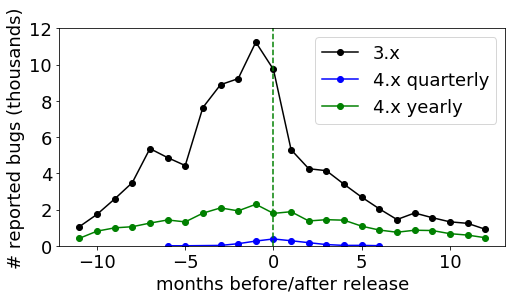

assigned_bugs
Per major release
3.x
At least one sample not normally distributed
MANN WHITNEY U
Statistically significant difference found
MannwhitneyuResult(statistic=28.0, pvalue=0.0060114127038087195)
0.6111111111111112
large
4.x quarterly
At least one sample not normally distributed
MANN WHITNEY U
Statistically significant difference NOT found
MannwhitneyuResult(statistic=15.5, pvalue=0.3739604639824475)
4.x yearly
At least one sample not normally distributed
MANN WHITNEY U
Statistically significant difference NOT found
MannwhitneyuResult(statistic=54.0, pvalue=0.15610810281867427)


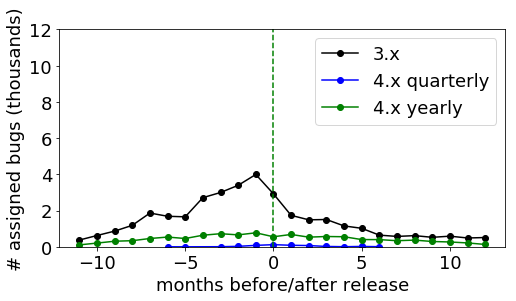

resolved_bugs
Per major release
3.x
At least one sample not normally distributed
MANN WHITNEY U
Statistically significant difference NOT found
MannwhitneyuResult(statistic=45.0, pvalue=0.06301106088518654)
4.x quarterly
At least one sample not normally distributed
MANN WHITNEY U
Statistically significant difference NOT found
MannwhitneyuResult(statistic=13.0, pvalue=0.23519650221932387)
4.x yearly
At least one sample not normally distributed
MANN WHITNEY U
Statistically significant difference NOT found
MannwhitneyuResult(statistic=57.0, pvalue=0.20125191189100178)


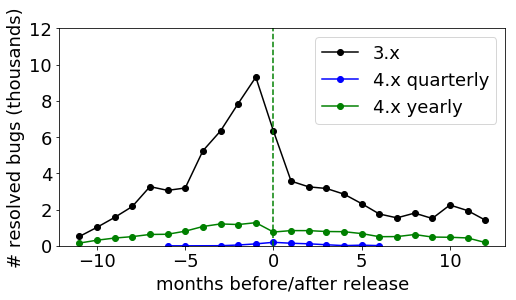

fixed_bugs
Per major release
3.x
At least one sample not normally distributed
MANN WHITNEY U
Statistically significant difference found
MannwhitneyuResult(statistic=32.0, pvalue=0.01128803126156679)
0.5555555555555556
large
4.x quarterly
At least one sample not normally distributed
MANN WHITNEY U
Statistically significant difference NOT found
MannwhitneyuResult(statistic=13.0, pvalue=0.23519650221932387)
4.x yearly
At least one sample not normally distributed
MANN WHITNEY U
Statistically significant difference NOT found
MannwhitneyuResult(statistic=51.0, pvalue=0.11829204666093807)


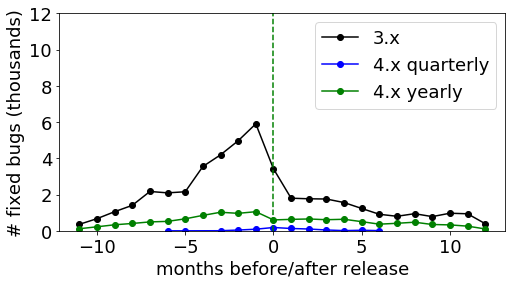

In [12]:
def get_major_label(release):
    if release.find('3.')>=0:
        return '3.x'

    if release=='4.9' or release=='4.10':
        return '4.x quarterly'
    return '4.x yearly'


varslist = ['reported_bugs','assigned_bugs','resolved_bugs','fixed_bugs']

for var in varslist:
    print(var)
    print('Per major release')
    data = all_stats.copy()
    data['major_release'] = data.apply(lambda x: get_major_label(str(x['release'])), axis=1)

    data = data[['release','month','period',var,'major_release']] 
    dat = data.groupby(by=['major_release','period','month'])[var].sum().reset_index()

    var1 = 'before'
    var2 = 'after'
    
    for mrel in dat.major_release.unique():    
        print(mrel)
        tt = pd.DataFrame()
        tt[var1]=dat[(dat['major_release']==mrel) & (dat['period']==var1)][var].values.tolist()
        tt[var2]=dat[(dat['major_release']==mrel) & (dat['period']==var2)][var].values.tolist()

        compare_distributions(tt,var1,var2,True)


    data = all_stats.copy()
    data['month'] = data.apply(lambda x : get_month_for_unified_figure(x),axis=1)
    data = data[['release','month',var]] 
    data = data.sort_values(by=['release','month'])

    
    data['major_release'] = data.apply(lambda x: get_major_label(x['release']), axis=1)

    data['month'] = data.apply(lambda x: x['month']+1 if x['month']<0 else x['month'], axis=1)

    data= data.groupby(by=['major_release','month'])[var].sum().reset_index()


    plt.figure(figsize=(8,4))
    c=0
    for rel in data.major_release.unique().tolist():
        ax = plt.gca()
        value = data[(data['major_release']==rel)].drop_duplicates()
        value[var] = value[var]/1000

        value.plot(x='month',y=var,label=rel,ax=ax,color=sorted_names[c],marker='o')
        c+=1

    plt.axvline(x=0, c='g',linestyle='--')
    plt.ylabel(figure_labels[var]+' (thousands)',fontsize=18)
    plt.xlabel('months before/after release',fontsize=18)

    plt.ylim(0,12)

    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(18) 

    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(18) 

    ax.legend(fontsize=18,  loc=1)

    plt.show()

    ax.get_figure().savefig(FIGS_PATH+os.sep+'rq0_monthly_'+var+'.pdf', bbox_inches="tight")